# EXERCÍCIO 4
PROPOSTO PELO PROF JULIANO DA PUCRS NA AULA 5 DA DISCIPLINA DE PRÉ-PROCESSAMENTO DE DADOS NO CURSO DE PÓS GRADUAÇÃO EM CIÊNCIA DE DADOS E INTELIGÊNCIA ARTIFICIAL DA PUCRS - TURMA 2-2021

Neste exercício serão utilizados arquivos csv com dados de transações de cartão de crédito e de diagnóstico de câncer para exercitar técnicas como normalização e redução de dimensionalidade. 

# Introdução
imports de bibliotecas python e montando g-drive

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, classification_report, accuracy_score

In [2]:
#   Por serem arquivos pequenos e que estavam disponibilizados em um dropbox  
# de terceiros (portanto, cuja duração do link de download seria desconhecida), 
# os arquivos foram salvos no google drive em que está salvo este colab e de lá 
# serão importados.

from google.colab import drive
drive.mount('/content/gdrive')
folder_gdrive = '/content/gdrive/My Drive/Data Science/Python/2021-22 PUCRS Pós/Disciplina 5 Pré-processamento de Dados/Prof Juliano PUCRS/Aula 5/Datasets/'

Mounted at /content/gdrive


# EXERCÍCIO 1 - Cartão de Crédito
Fonte: kaggle.com/arjunbhasin2013/ccdata 

In [3]:
# Item 1: Importando o arquivo .csv em um pandas DataFrame e visualizando o cabeçalho do df resultante
dfCreditCard  = pd.read_csv(folder_gdrive + 'CC_DATASET.CSV')
dfCreditCard.head(5)

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


## Descrição dos dados

(copiado do kaggle)

CUSTID : Identification of Credit Card holder (Categorical)

BALANCE : Balance amount left in their account to make purchases 

BALANCEFREQUENCY : How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)

PURCHASES : Amount of purchases made from account

ONEOFFPURCHASES : Maximum purchase amount done in one-go

INSTALLMENTSPURCHASES : Amount of purchase done in installment

CASHADVANCE : Cash in advance given by the user

PURCHASESFREQUENCY : How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)

ONEOFFPURCHASESFREQUENCY : How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)

PURCHASESINSTALLMENTSFREQUENCY : How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)

CASHADVANCEFREQUENCY : How frequently the cash in advance being paid

CASHADVANCETRX : Number of Transactions made with "Cash in Advanced"

PURCHASESTRX : Numbe of purchase transactions made

CREDITLIMIT : Limit of Credit Card for user

PAYMENTS : Amount of Payment done by user

MINIMUM_PAYMENTS : Minimum amount of payments made by user

PRCFULLPAYMENT : Percent of full payment paid by user

TENURE : Tenure of credit card service for user

## Item 2: Tratamento de Outliers
LIVRE ESCOLHA ENTRE SOBRESCREVER COM ZEROS, COM MÉDIA/MEDIANA OU REMOÇÃO DOS DADOS

In [4]:
# Uma breve avaliação dos dados
dfCreditCard.describe()
# Percebe-se inicialmente que quase todas as features possuem 8950 entradas, 
#   porém CREDIT_LIMIT e MINIMUM_PAYMENTS não.
# Comparando médias e medianas, percebe-se que sao valores muitíssimo divergentes. 
#  Pela característica dos dados, talvez isto faça sentido, não sei. 
#  Definitivamente, é difícil de remover valores muito altos porque poderiam
#  de fato ter ocorrido essas transações.
# Estudando a descrição das features, colada abaixo copiada do kaggle, 
#  pode-se interpretar um pouco melhor os dados. Por exemplo, a feature
#  PURCHASES representa quantidade de compras realizadas pelo comprador, 
#  e o valor mais algo indica 1 bilhão de compras. Isto é difícil de ser
#  verdade, considerando que o intervalo é de 6 meses (a nao ser que seja
#  uma conta corporativa de uma grande empresa). Provavelmente é um valor
#  extremo incorreto.

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8.950000e+03,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8.949000e+03,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1.127347e+05,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,1.162369e+05,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,1.057032e+07,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,1.057087e+07,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000e+01,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,3.963500e+01,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1.600000e+03,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,3.612800e+02,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3.000000e+03,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1.110130e+03,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6.500000e+03,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,1.000000e+09,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,1.000000e+09,50721.483360,76406.207520,1.000000,12.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f47f34cb4d0>,
      dtype=object)

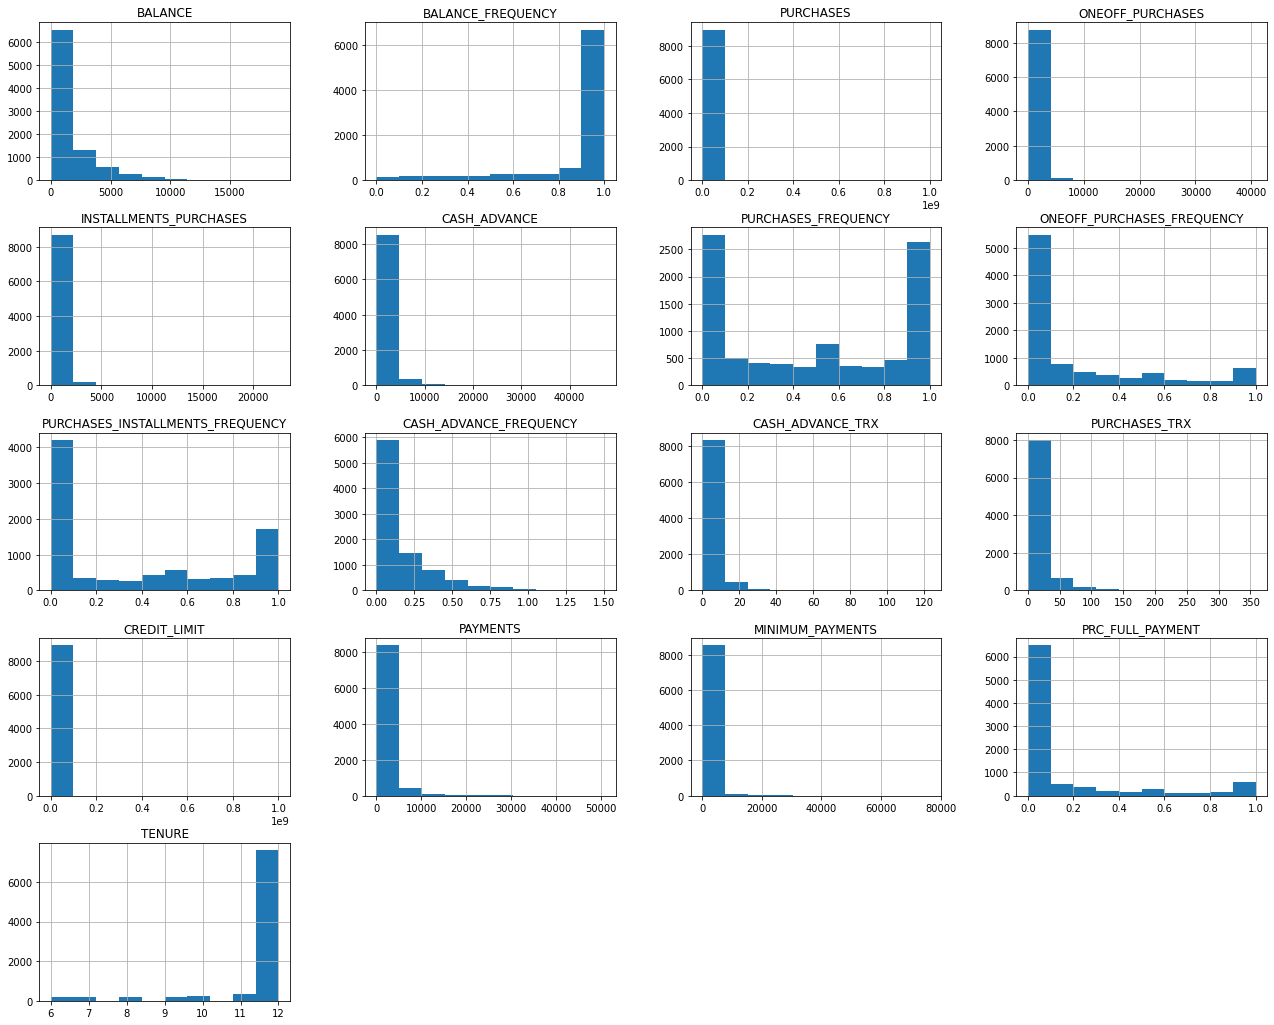

In [5]:
# Utilizemos gráfico de histograma para auxiliar na análise
dfCreditCard.hist(figsize=[22,18])

Principais Candidatos de outliers e valores extremos:

> Purchases e Credit_Limit

Além disso, 

> OneOffPurchases, Installments_Purchases, Cash_Advance, Cash_Advance_Trx, Purchases_Trx, Payments, Minimum Payments 

todos estes também parecem ter outliers distorcendo os dados (o que pode ser causado por uma grande quantidade de valores 0
ou poucas ocorrências de valores altos). 

Trataremos inicialmente Purchases e Credit_Limit, iniciando por Purchases

Obs.: como a intenção é agrupar perfis, estes dados serão cortados do dataset pois são pequenos valor que distorcem o perfil dos dados, e não representam a massa dos dados. 

### PURCHASES

In [6]:

# Buscando percentil que será utilizado para corte
purch_pct_cut = 0.015 # Valor em % dos dados que cortaremos -> 0,015 %
purch_qtl_cut = 1-(purch_pct_cut/100)
#dfCreditCard['PURCHASES'].quantile(purch_qtl_cut)   # 0.1% -> 27799 
dfCreditCard['PURCHASES'].quantile(purch_qtl_cut)    # 0.015% -> 46304
#dfCreditCard['PURCHASES'].quantile(purch_qtl_cut)   # 0.01% -> 105143885

46304.477650508095

In [7]:
# Antes de realizar a remoção, verificando quantos dados existem acima de 40000
dfCreditCard[ dfCreditCard['PURCHASES'] >= 40000 ].count()['PURCHASES'] # 4

4

In [8]:
# Mantendo apenas valores que estão abaixo o quantil especificado
dfCreditCard_purch015 = dfCreditCard[ dfCreditCard['PURCHASES'] < dfCreditCard['PURCHASES'].quantile(purch_qtl_cut) ]


In [9]:
# Após remover dados altos, verificando quantos dados existem acima de 40000
dfCreditCard_purch015[ dfCreditCard_purch015['PURCHASES'] >= 40000 ].count()['PURCHASES'] # 2 - ok, removeu os valores mais altos

2

In [10]:
# Breve análise dos dados resultantes de PURCHASES
dfCreditCard_purch015['PURCHASES'].describe()  # agora média e mediana são valores em grandeza similar

count     8948.000000
mean       997.558695
std       2075.475758
min          0.000000
25%         39.570000
50%        361.035000
75%       1109.935000
max      41050.400000
Name: PURCHASES, dtype: float64

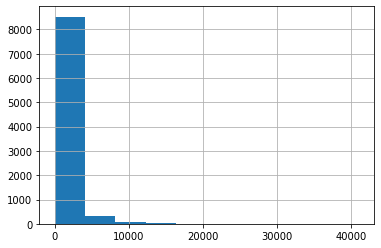

In [11]:
# Verificando o histograma
dfCreditCard_purch015['PURCHASES'].hist()  # Ainda há muitos outliers, 
# percebe-se que há pouquíssimas entradas acima de 10000. 
# Fica difícil analisar o perfil das compras assim. Vale a pena
# remover mais valores. 

In [12]:
# Repetindo a remoção de valores altos, agora cortaremos uma parcela maior
purch_pct_cut = 0.5 # Valor em % dos dados que cortaremos -> 0,5 %
purch_qtl_cut = 1-(purch_pct_cut/100)
dfCreditCard['PURCHASES'].quantile(purch_qtl_cut)    # 0.5% -> 11658


11731.775549999842

In [13]:
# Mantendo apenas valores que estão abaixo o quantil especificado
dfCreditCard_purch5= dfCreditCard[ dfCreditCard['PURCHASES'] < dfCreditCard['PURCHASES'].quantile(purch_qtl_cut) ]

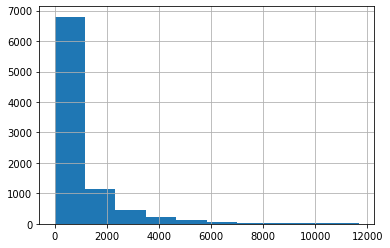

In [14]:
# Verificando o histograma novamente
dfCreditCard_purch5['PURCHASES'].hist() # Agora segue com poucos valores altos, 
# mas já menos disparsos. 

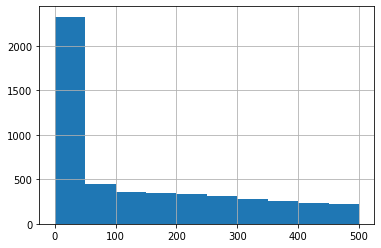

In [15]:
# Só por curiosidade, analisemos o espectro baixo dos dados. Verificamos que 
# realmente há muitíssimos valores em 0
dfCreditCard_purch5[ dfCreditCard_purch5['PURCHASES'] < 500 ]['PURCHASES'].hist() 

In [16]:
dfCreditCard_purch5[ dfCreditCard_purch5['PURCHASES'] == 0 ]['PURCHASES'].count() # de fato há 2000 dados zerados

2044

Assim, utilizaremos adiante os dados com a remoção dos 0,5% valores mais altos de purchase.

### CREDIT LIMIT

Iniciando comparando CREDIT_LIMIT original com após tratamento de purchases

In [17]:
# Avaliação dos dados originais
dfCreditCard['CREDIT_LIMIT'].describe()

count    8.949000e+03
mean     1.162369e+05
std      1.057087e+07
min      5.000000e+01
25%      1.600000e+03
50%      3.000000e+03
75%      6.500000e+03
max      1.000000e+09
Name: CREDIT_LIMIT, dtype: float64

In [18]:
# Avaliando como ficaram os dados de CREDIT_LIMIT após o tratamento anterior
dfCreditCard_purch5['CREDIT_LIMIT'].describe()
# Houve muito pouca alteração do quadro geral (média, desvio padrão e quartis),
# e o valor outlier segue presente

count    8.904000e+03
mean     1.167541e+05
std      1.059755e+07
min      5.000000e+01
25%      1.500000e+03
50%      3.000000e+03
75%      6.150000e+03
max      1.000000e+09
Name: CREDIT_LIMIT, dtype: float64

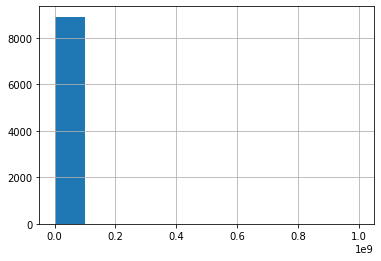

In [19]:
# Avaliação do histograma
dfCreditCard_purch5['CREDIT_LIMIT'].hist()
# Percebe-se que uma quantidade baixíssima de valores está distorcendo o gráfico

In [20]:
## Novamente, talvez se faça necessária aplicação de dois percentis de 
# cortes de outliers, iniciaremos buscando um valor mais baixo para verificar

credlim_pct_cut = 0.015 # Valor em % dos dados que cortaremos -> 0,015 %
credlim_qtl_cut = 1-(credlim_pct_cut/100)
#dfCreditCard_purch5['CREDIT_LIMIT'].quantile(credlim_qtl_cut)   # 0.1% -> 20548
dfCreditCard_purch5['CREDIT_LIMIT'].quantile(credlim_qtl_cut)    # 0.015% -> 28322
#dfCreditCard_purch5['CREDIT_LIMIT'].quantile(credlim_qtl_cut)   # 0.01% -> 109726708


28322.74999999754

In [21]:
# Mantendo apenas valores que estão abaixo o quantil especificado
dfCreditCard_credlim015 = dfCreditCard_purch5[ 
                            dfCreditCard_purch5['CREDIT_LIMIT'] < 
                              dfCreditCard_purch5['CREDIT_LIMIT'].quantile(credlim_qtl_cut) ]

In [22]:
# Avaliação após remoção dos 0,015% dados mais altos
dfCreditCard_credlim015['CREDIT_LIMIT'].describe()
# agora valor de média e de mediana já são mais compatíveis.
# Vamos verificar visualmente a distribuição dos dados

count     8902.000000
mean      4442.639646
std       3550.125308
min         50.000000
25%       1500.000000
50%       3000.000000
75%       6100.000000
max      25000.000000
Name: CREDIT_LIMIT, dtype: float64

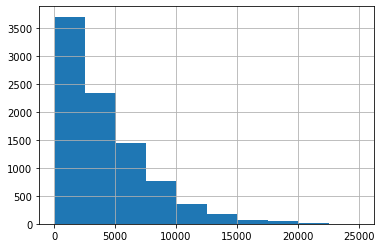

In [23]:
dfCreditCard_credlim015['CREDIT_LIMIT'].hist()
# O histograma com o corte de 0,015% dos créditos mais altos já ficou com uma divisão ok dos grupos

## Item 3: Valores ausentes

In [24]:
dfCreditCard_credlim015.isna().sum()
# há valores ausentes apenas em Minium Payments, 
# substituiremos por 0

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          0
PAYMENTS                              0
MINIMUM_PAYMENTS                    312
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [25]:
dfCreditCard_credlim015=dfCreditCard_credlim015.fillna(value=0)

In [26]:
dfCreditCard_credlim015.isna().sum().sum() # = 0, ok foram removidos

0

In [27]:
dfCreditCard_treated = dfCreditCard_credlim015

## Item 4: Normalização
Aplicar normalização sobre as variáveis numéricas

In [28]:
# Instanciando o normalizador
estandarizador = StandardScaler()

In [29]:
# Treinando o estandarizador a partir dos dados numéricos 
# - removendo coluna não-numérica
estandarizador.fit(dfCreditCard_treated.drop(['CUST_ID'],axis=1))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [30]:
# Realizando a normalização dos dados de fato e atribuindo a um dataframe novo normalizado
valoresEstand = estandarizador.transform(dfCreditCard_treated.drop(['CUST_ID'],axis=1))
dfCreditCard_norm = pd.DataFrame(valoresEstand, 
                                 columns = dfCreditCard_treated.drop(['CUST_ID'],axis=1).columns )
dfCreditCard_norm.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8.902000e+03,8.902000e+03,8.902000e+03,8.902000e+03,8.902000e+03,8.902000e+03,8.902000e+03,8.902000e+03,8.902000e+03,8.902000e+03,8.902000e+03,8.902000e+03,8.902000e+03,8.902000e+03,8.902000e+03,8.902000e+03,8.902000e+03
mean,-2.242646e-16,-7.160539e-15,3.993398e-15,1.905912e-16,5.330168e-15,-4.214894e-15,2.201177e-16,3.571471e-15,1.234341e-15,1.523844e-15,-7.477106e-16,-8.120068e-15,5.184899e-15,2.070288e-17,3.700141e-16,-2.895921e-15,1.124461e-14
std,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00
min,-7.534561e-01,-3.697411e+00,-6.170927e-01,-4.776723e-01,-5.254051e-01,-4.688346e-01,-1.217789e+00,-6.752854e-01,-9.143857e-01,-6.767985e-01,-4.769202e-01,-6.205839e-01,-1.237389e+00,-6.639147e-01,-3.555627e-01,-5.233762e-01,-4.116536e+00
25%,-6.919013e-01,5.042593e-02,-5.913733e-01,-4.776723e-01,-5.254051e-01,-4.688346e-01,-1.010011e+00,-6.752854e-01,-9.143857e-01,-6.767985e-01,-4.769202e-01,-5.768069e-01,-8.289299e-01,-5.095418e-01,-2.852437e-01,-5.233762e-01,3.612438e-01
50%,-3.313111e-01,5.189050e-01,-3.717377e-01,-4.454312e-01,-4.063233e-01,-4.688346e-01,2.888534e-02,-3.934486e-01,-4.945215e-01,-6.767985e-01,-4.769202e-01,-3.141449e-01,-4.063858e-01,-3.205061e-01,-2.313112e-01,-5.233762e-01,3.612438e-01
75%,2.305239e-01,5.189050e-01,1.289926e-01,4.129313e-02,1.056899e-01,6.601914e-02,1.067782e+00,1.702284e-01,9.749993e-01,4.330816e-01,1.089144e-01,1.236250e-01,4.668718e-01,9.843021e-02,-1.678553e-02,-3.254386e-02,3.612438e-01
max,8.246000e+00,5.189050e-01,7.367608e+00,1.028313e+01,1.315059e+01,2.212058e+01,1.275560e+00,2.706770e+00,1.604794e+00,6.814900e+00,1.753749e+01,1.290651e+01,5.790927e+00,1.577473e+01,3.261824e+01,2.912454e+00,3.612438e-01


## Item 5: Clusterização
Aplicar K-means sobre os dados normalizados em 2 e em 3 clusters

### k = 2 clusters

In [31]:
k = 2

In [32]:
# Instanciando o K-Means
modeloKM2 = KMeans(n_clusters=k)
# Fitando modelo com dados normalizados
modeloKM2.fit(X=dfCreditCard_norm)
# Adicionando ao DF original (não-normalizado, mas tratado)
dfCreditCard_treated['ClusterK'+str(k)] = pd.DataFrame(modeloKM2.labels_).values

In [33]:
dfCreditCard_treated.head(10)

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,ClusterK2
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,0
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,0
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,1
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,0.000000,0.000000,12,0
4,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,0
5,C10006,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,0.666667,0.000000,0.583333,0.000000,0,8,1800.0,1400.057770,2407.246035,0.000000,12,1
6,C10007,627.260806,1.000000,7091.01,6402.63,688.38,0.000000,1.000000,1.000000,1.000000,0.000000,0,64,13500.0,6354.314328,198.065894,1.000000,12,1
7,C10008,1823.652743,1.000000,436.20,0.00,436.20,0.000000,1.000000,0.000000,1.000000,0.000000,0,12,2300.0,679.065082,532.033990,0.000000,12,1
8,C10009,1014.926473,1.000000,861.49,661.49,200.00,0.000000,0.333333,0.083333,0.250000,0.000000,0,5,7000.0,688.278568,311.963409,0.000000,12,0
9,C10010,152.225975,0.545455,1281.60,1281.60,0.00,0.000000,0.166667,0.166667,0.000000,0.000000,0,3,11000.0,1164.770591,100.302262,0.000000,12,0


### k = 3 clusters

In [34]:
k = 3

In [35]:
# Instanciando o K-Means
modeloKM3 = KMeans(n_clusters=k)
# Fitando modelo com dados normalizados
modeloKM3.fit(X=dfCreditCard_norm)
# Adicionando ao DF original (não-normalizado, mas tratado) em outra coluna
dfCreditCard_treated['ClusterK'+str(k)] = pd.DataFrame(modeloKM3.labels_).values

In [36]:
dfCreditCard_treated.head(10)

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,ClusterK2,ClusterK3
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,0,1
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,0,2
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,1,1
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,0.000000,0.000000,12,0,1
4,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,0,1
5,C10006,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,0.666667,0.000000,0.583333,0.000000,0,8,1800.0,1400.057770,2407.246035,0.000000,12,1,1
6,C10007,627.260806,1.000000,7091.01,6402.63,688.38,0.000000,1.000000,1.000000,1.000000,0.000000,0,64,13500.0,6354.314328,198.065894,1.000000,12,1,0
7,C10008,1823.652743,1.000000,436.20,0.00,436.20,0.000000,1.000000,0.000000,1.000000,0.000000,0,12,2300.0,679.065082,532.033990,0.000000,12,1,1
8,C10009,1014.926473,1.000000,861.49,661.49,200.00,0.000000,0.333333,0.083333,0.250000,0.000000,0,5,7000.0,688.278568,311.963409,0.000000,12,0,1
9,C10010,152.225975,0.545455,1281.60,1281.60,0.00,0.000000,0.166667,0.166667,0.000000,0.000000,0,3,11000.0,1164.770591,100.302262,0.000000,12,0,1


## Item 6: Análise de dados
Verificando os grupos com um gráfico de dispersão sobre duas métricas. Selecionaremos Credit Limit com Purchases, para verificar se a relação de limite do cartão de crédito com o quanto do mesmo é utilizado está relacionado ao agrupamento.

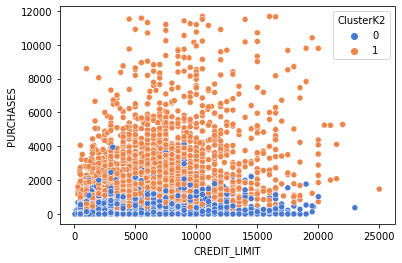

In [37]:
# Plotando inicialmente o agrupamento com k = 2
sns.scatterplot(data=dfCreditCard_treated, x="CREDIT_LIMIT", y="PURCHASES", hue="ClusterK2",palette="muted")
# Vemos que o K-Means agrupou principalmente valores de compra baixos no grupo 0 
# e um pouco maiores no grupo 1, mas não exclusivamente. 

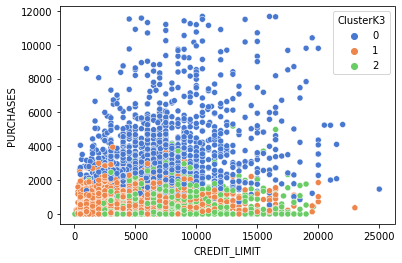

In [38]:
# Plotando inicialmente o agrupamento com k = 3
sns.scatterplot(data=dfCreditCard_treated, x="CREDIT_LIMIT", y="PURCHASES", hue="ClusterK3",palette="muted")
# Estes não parecem bons parâmetros para a separação dos grupos. 
#   Talvez purchases para separar grupo 0 d os outros dois, mas não
#   para separar entre grupo 1 e grupo 2

### Comparando os agrupamentos

In [39]:
# Verificando quantidade de casos enquadrados em cada grupo
dfCreditCard_treated['ClusterK2'].value_counts()

0    5439
1    3463
Name: ClusterK2, dtype: int64

In [40]:
# Verificando quantidade de casos enquadrados em cada grupo
dfCreditCard_treated['ClusterK3'].value_counts()

1    6008
2    1546
0    1348
Name: ClusterK3, dtype: int64

In [41]:
# Verificando média e mediana de valor de compras de cada cluster em cada agrupamento
dfCreditCard_treated.groupby(by='ClusterK2')['PURCHASES'].describe()

,count,mean,std,min,25%,50%,75%,max
ClusterK2,,,,,,,,
0,5439.0,267.130673,414.476650,0.0,0.000,95.0,361.610,4139.56
1,3463.0,1901.206090,1897.861823,8.4,599.475,1293.7,2476.675,11681.64


In [42]:
# Verificando média e mediana de valor de compras de cada cluster em cada agrupamento
dfCreditCard_treated.groupby(by='ClusterK3')['PURCHASES'].describe()

,count,mean,std,min,25%,50%,75%,max
ClusterK3,,,,,,,,
0,1348.0,3510.435668,2107.823921,534.26,2074.0700,2864.12,4345.2000,11681.64
1,6008.0,463.576232,526.434761,0.00,50.9475,291.20,689.6775,3950.00
2,1546.0,336.071889,614.079386,0.00,0.0000,0.00,435.1050,5197.22


In [43]:
# Verificando mediana do limite de crédito de cada grupo em k=3
dfCreditCard_treated.groupby(by='ClusterK3')['CREDIT_LIMIT'].describe()
# reforça que esta não é uma variável muito relevante no agrupamento aparentemente

,count,mean,std,min,25%,50%,75%,max
ClusterK3,,,,,,,,
0,1348.0,7151.038576,4046.034156,450.0,4000.0,6500.0,9500.0,25000.0
1,6008.0,3253.490943,2654.570877,150.0,1500.0,2500.0,4000.0,23000.0
2,1546.0,6702.331530,3732.472486,50.0,4000.0,6000.0,9000.0,19600.0


# EXERCÍCIO 2 - Diagnósticos de Câncer
Fonte: kaggle.com/uciml/breast-cancer-wisconsin-data 

In [44]:
# Item 1: Importando o arquivo .csv em um pandas DataFrame e visualizando o cabeçalho do df resultante
dfDiagCancer  = pd.read_csv(folder_gdrive + 'DIAG_CANCER.CSV')
dfDiagCancer.head(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Item 2: Tratamento de outliers

In [45]:
dfDiagCancer.describe()
# Aparentemente só há outliers na extremidade superior da variável "radius_mean".

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
mean,3.037183e+07,717.046787,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,8361.207931,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,11.710000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,13.430000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,16.070000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN
max,9.113205e+08,100003.000000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


In [46]:
# Outliers serão substituídos pela mediana da mesma
radius_mean_Median = dfDiagCancer['radius_mean'].median()

In [47]:
# Buscando percentil que será utilizado para corte
diagcanc_radmean_pct_cut = 0.75 # Valor em % dos dados que cortaremos -> 0,75 %
diagcanc_radmean_qtl_cut = 1-(diagcanc_radmean_pct_cut/100)

#dfDiagCancer['radius_mean'].quantile(diagcanc_radmean_qtl_cut) # 1% -> 27.28
diagcanc_radmean_qtl = dfDiagCancer['radius_mean'].quantile(diagcanc_radmean_qtl_cut) # 0.75% -> 27.93
#dfDiagCancer['radius_mean'].quantile(diagcanc_radmean_qtl_cut) # 0.5% -> 100000
#dfDiagCancer['radius_mean'].quantile(diagcanc_radmean_qtl_cut) # 0.1% -> 100002

In [48]:
# Substituindo os valores acima do quantil de corte e atribuindo a uma nova coluna
dfDiagCancer['radius_mean'] = np.where(
                                        dfDiagCancer['radius_mean'] > diagcanc_radmean_qtl, 
                                        radius_mean_Median, 
                                        dfDiagCancer['radius_mean']   )
                                      # Valores acima do máximo substituídos pela mediana

In [49]:
# Verificando o resultado da operação
dfDiagCancer['radius_mean'].describe()   # ok

count    569.000000
mean      14.117156
std        3.464369
min        6.981000
25%       11.710000
50%       13.430000
75%       15.780000
max       27.420000
Name: radius_mean, dtype: float64

## Item 3: Remoção da variável que só possui valores ausentes

In [50]:
dfDiagCancer.drop(labels='Unnamed: 32', axis=1, inplace=True)
dfDiagCancer.head(3)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


## Item 4: Normalização: aplicar Standard Scaler sobre as variáveis numéricas

In [51]:
# Instanciando o normalizador
estandarizadorCanc = StandardScaler()

In [52]:
# Treinando o estandarizador a partir dos dados numéricos 
# - removendo coluna não-numérica
estandarizadorCanc.fit(dfDiagCancer.drop(['id', 'diagnosis'],axis=1))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [53]:
# Realizando a normalização dos dados de fato e atribuindo a um dataframe novo normalizado
valoresEstandCanc = estandarizadorCanc.transform(dfDiagCancer.drop(['id', 'diagnosis'],axis=1))
dfDiagCancer_norm = pd.DataFrame(valoresEstandCanc, 
                                 columns = dfDiagCancer.drop(['id', 'diagnosis'],axis=1).columns )
dfDiagCancer_norm.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02
mean,1.705334e-16,1.049736e-16,-1.272171e-16,-1.900452e-16,1.490704e-16,2.544342e-16,-1.338511e-16,-8.429110e-17,2.081912e-16,5.408679e-16,2.475807e-16,-9.912009e-17,-2.968237e-16,-1.088760e-16,4.426014e-16,1.958988e-16,1.678017e-16,2.185325e-17,1.523874e-16,-5.658430e-17,-7.988142e-16,-1.834112e-17,-4.015534e-16,-2.848727e-17,-2.189227e-16,-2.579464e-16,1.143393e-16,2.829215e-16,1.670212e-16,2.321908e-16
std,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00
min,-2.061684e+00,-2.229249e+00,-1.984504e+00,-1.454443e+00,-3.112085e+00,-1.610136e+00,-1.114873e+00,-1.261820e+00,-2.744117e+00,-1.819865e+00,-1.059924e+00,-1.554264e+00,-1.044049e+00,-7.378291e-01,-1.776065e+00,-1.298098e+00,-1.057501e+00,-1.913447e+00,-1.532890e+00,-1.096968e+00,-1.726901e+00,-2.223994e+00,-1.693361e+00,-1.222423e+00,-2.682695e+00,-1.443878e+00,-1.305831e+00,-1.745063e+00,-2.160960e+00,-1.601839e+00
25%,-6.954439e-01,-7.259631e-01,-6.919555e-01,-6.671955e-01,-7.109628e-01,-7.470860e-01,-7.437479e-01,-7.379438e-01,-7.032397e-01,-7.226392e-01,-6.235706e-01,-6.948092e-01,-6.237679e-01,-4.947542e-01,-6.240183e-01,-6.929263e-01,-5.571612e-01,-6.744900e-01,-6.516807e-01,-5.851185e-01,-6.749213e-01,-7.486293e-01,-6.895783e-01,-6.421359e-01,-6.912304e-01,-6.810833e-01,-7.565142e-01,-7.563999e-01,-6.418637e-01,-6.919118e-01
50%,-1.985242e-01,-1.046362e-01,-2.359800e-01,-2.951869e-01,-3.489108e-02,-2.219405e-01,-3.422399e-01,-3.977212e-01,-7.162650e-02,-1.782793e-01,-2.922452e-01,-1.974976e-01,-2.866520e-01,-3.477828e-01,-2.203352e-01,-2.810204e-01,-1.990654e-01,-1.404958e-01,-2.194304e-01,-2.299405e-01,-2.690395e-01,-4.351564e-02,-2.859802e-01,-3.411812e-01,-4.684277e-02,-2.695009e-01,-2.182321e-01,-2.234689e-01,-1.274095e-01,-2.164441e-01
75%,4.804069e-01,5.841756e-01,4.996769e-01,3.635073e-01,6.361990e-01,4.938569e-01,5.260619e-01,6.469351e-01,5.307792e-01,4.709834e-01,2.660996e-01,4.665523e-01,2.430307e-01,1.067726e-01,3.683553e-01,3.896541e-01,3.367521e-01,4.726567e-01,3.556925e-01,2.886421e-01,5.220158e-01,6.583411e-01,5.402790e-01,3.575891e-01,5.975448e-01,5.396688e-01,5.311411e-01,7.125100e-01,4.501382e-01,4.507624e-01
max,3.843282e+00,4.651889e+00,3.976130e+00,5.250529e+00,4.770911e+00,4.568425e+00,4.243589e+00,3.927930e+00,4.484751e+00,4.910919e+00,8.906909e+00,6.655279e+00,9.461986e+00,1.104184e+01,8.029999e+00,6.143482e+00,1.207268e+01,6.649601e+00,7.071917e+00,9.851593e+00,4.094189e+00,3.885905e+00,4.287337e+00,5.930172e+00,3.955374e+00,5.112877e+00,4.700669e+00,2.685877e+00,6.046041e+00,6.846856e+00


## Item 5: Redução de dimensionalidade

### a) Aplique PCA sobre os dados normalizados para obter 5 variáveis

In [54]:
# Instanciando o PCA para obter 5 componentes principais
pcaDiagCanc = PCA(n_components=5)

# Fitando o modelo PCA a partir dos dados normalizados
pcaDiagCanc.fit(dfDiagCancer_norm)

# Transformando os dados nas variáveis do PCA
X_pcaDiagCanc = pcaDiagCanc.transform(dfDiagCancer_norm)

### b) Crie um novo df com as variáveis resultantes do PCA e adicione ao mesmo a variável de desfecho

In [55]:
# Criando o novo DF com os dados transformados pelo PCA
dfDiagCancer_PCA = pd.DataFrame(data = X_pcaDiagCanc, columns=['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5'])

In [56]:
# Adicionando a variável de desfecho
dfDiagCancer_PCA['diagnosis'] = dfDiagCancer['diagnosis']

In [57]:
# Verificando o resultado
dfDiagCancer_PCA.head(5)

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,diagnosis
0,9.202334,1.921429,-1.109726,3.648035,-1.199368,M
1,2.383939,-3.782980,-0.522029,1.121228,0.629259,M
2,5.737684,-1.099769,-0.543408,0.918496,-0.172643,M
3,7.152017,10.245263,-3.272137,0.130688,-2.960245,M
4,3.931900,-1.951433,1.386921,2.944389,0.563307,M


## Item 7: Modelagem

### a) ML nos dados originais
Crie um modelo de classificação (livre escolha) e aplique sobre os dados originais, sua avaliando acurácia e os resultados de matriz de confusão.

In [58]:
# Primeiro, selecionando as features e as labels
featuresDiagCanc = dfDiagCancer.drop(labels=['id', 'diagnosis'], axis=1).values
labelsDiagCanc = dfDiagCancer['diagnosis'].values

In [59]:
# Então, vamos dividir entre dados de treino e dados de teste 
# em uma razão de 85/15 (pois há poucos dados (569))
X_train_DiagCanc, X_test_DiagCanc, y_train_DiagCanc, y_test_DiagCanc = train_test_split(
                                                    featuresDiagCanc, labelsDiagCanc, 
                                                    train_size=0.85, random_state=0)

In [60]:
# Utilizaremos RandomForest para este exercício.
# Então, começamos instanciando o classificador
clfRFDiagCanc = RandomForestClassifier(random_state=0, oob_score=True)

In [61]:
# Após, faz-se o treinamento do mesmo
clfRFDiagCanc.fit(X_train_DiagCanc, y_train_DiagCanc)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=0, verbose=0,
                       warm_start=False)

In [62]:
# Agora, realizar a previsão dos dados teste
y_pred_DiagCanc = clfRFDiagCanc.predict(X_test_DiagCanc)

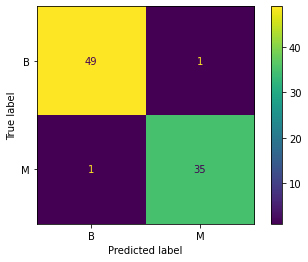

In [63]:
# Pronto, agora é hora de avaliações de acurácia, 
# iniciando pela confusion matrix
plot_confusion_matrix(clfRFDiagCanc, X_test_DiagCanc, y_test_DiagCanc)
# Conseguimos perceber que houve 1 erro tipo A e 1 erro tipo B nas previsões

In [64]:
# Realizando a avaliação com classification report e accuracy_score
print(classification_report(y_test_DiagCanc,y_pred_DiagCanc))
print(accuracy_score(y_test_DiagCanc, y_pred_DiagCanc))


              precision    recall  f1-score   support

           B       0.98      0.98      0.98        50
           M       0.97      0.97      0.97        36

    accuracy                           0.98        86
   macro avg       0.98      0.98      0.98        86
weighted avg       0.98      0.98      0.98        86

0.9767441860465116


### b) ML nos dados de dimensões reduzidas pelo PCA

In [65]:
# Primeiro, selecionando as features e as labels
featuresDiagCanc_PCA = dfDiagCancer_PCA.drop(labels='diagnosis', axis=1).values
labelsDiagCanc_PCA = dfDiagCancer_PCA['diagnosis'].values

In [66]:
# Então, vamos dividir entre dados de treino e dados de teste 
# em uma razão de 85/15 (pois há poucos dados (569))
X_train_DiagCanc_PCA, X_test_DiagCanc_PCA, y_train_DiagCanc_PCA, y_test_DiagCanc_PCA = train_test_split(
                                                    featuresDiagCanc_PCA, labelsDiagCanc_PCA, 
                                                    train_size=0.85, random_state=0)

In [67]:
# Então, começamos instanciando o classificador
clfRFDiagCanc_PCA = RandomForestClassifier(random_state=0, oob_score=True)

In [68]:
# Após, faz-se o treinamento do mesmo
clfRFDiagCanc_PCA.fit(X_train_DiagCanc_PCA, y_train_DiagCanc_PCA)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=0, verbose=0,
                       warm_start=False)

In [69]:
# Agora, realizar a previsão dos dados teste
y_pred_DiagCanc_PCA = clfRFDiagCanc_PCA.predict(X_test_DiagCanc_PCA)

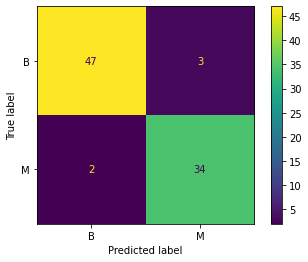

In [70]:
# Pronto, agora é hora de avaliações de acurácia, 
# iniciando pela confusion matrix
plot_confusion_matrix(clfRFDiagCanc_PCA, X_test_DiagCanc_PCA, y_test_DiagCanc_PCA)
# Conseguimos perceber que houve 1 erro tipo A e 1 erro tipo B nas previsões

In [71]:
# Realizando a avaliação com classification report e accuracy_score
print(classification_report(y_test_DiagCanc_PCA,y_pred_DiagCanc_PCA))
print(accuracy_score(y_test_DiagCanc_PCA, y_pred_DiagCanc_PCA))


              precision    recall  f1-score   support

           B       0.96      0.94      0.95        50
           M       0.92      0.94      0.93        36

    accuracy                           0.94        86
   macro avg       0.94      0.94      0.94        86
weighted avg       0.94      0.94      0.94        86

0.9418604651162791


### c) Compare os resultados de acurácia em ambos casos e avalia se houve perda relevante.

Houve uma piora de aproximadamente 3,5% na acurácia geral do modelo. Neste caso, temos mais interesse em reduzir o numero de falsos B, e este grupo aumentou em número de erros. Assim, não considero que tenha sido justificada a economia computacional, uma vez que pelo menos uma pessoa a mais possui diagnóstico incorreto de forma grave e não receberá o tratamento devido.